### Импорты

In [1]:
from LDANewsModel import LDANewsModel
from pyspark import SparkContext
from pyspark.sql import DataFrame, SparkSession

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

### Сессия Spark

In [2]:
sc = SparkContext('local[12]', 'LDAModel')
spark = SparkSession(sparkContext=sc)

# LDA на экономических новостях

## Загружаем данные

In [3]:
news_data = spark.read.parquet('data/russian_news.parquet').repartition(12).cache()
news_data.show(10)

+------+--------------------+
|    id|                text|
+------+--------------------+
|129268|
МОСКВА, 10 мар —...|
| 12026|МОСКВА, 28 янв - ...|
| 36225|МОСКВА, 23 мая — ...|
|125263|
МОСКВА, 10 апр —...|
| 43266|
МОСКВА, 29 ноя —...|
| 52730|
С.-ПЕТЕРБУРГ, 16...|
|128952|
МОСКВА, 12 мар —...|
| 90170|
МОСКВА, 19 апр —...|
| 47686|
МОСКВА, 29 авг —...|
| 35258|
МОСКВА, 5 июн — ...|
+------+--------------------+
only showing top 10 rows



## LDA модель


In [4]:
lda_model = LDANewsModel(news_data)
lda_results, vocab_model, predictions = lda_model.fit_predict(num_topics=25, thresholds=(3, 5))

+------+--------------------+--------------------+--------------------+--------------------+
|    id|                text|               words|              ngrams|      combined_words|
+------+--------------------+--------------------+--------------------+--------------------+
|129268|
МОСКВА, 10 мар —...|[москва, мар, риа...|[москва мар, мар ...|[москва, мар, риа...|
| 12026|МОСКВА, 28 янв - ...|[москва, янв, риа...|[москва янв, янв ...|[москва, янв, риа...|
| 36225|МОСКВА, 23 мая — ...|[москва, мая, риа...|[москва мая, мая ...|[москва, мая, риа...|
|125263|
МОСКВА, 10 апр —...|[москва, апр, риа...|[москва апр, апр ...|[москва, апр, риа...|
| 43266|
МОСКВА, 29 ноя —...|[москва, ноя, риа...|[москва ноя, ноя ...|[москва, ноя, риа...|
| 52730|
С.-ПЕТЕРБУРГ, 16...|[с, петербург, ма...|[с петербург, пет...|[с, петербург, ма...|
|128952|
МОСКВА, 12 мар —...|[москва, мар, риа...|[москва мар, мар ...|[москва, мар, риа...|
| 90170|
МОСКВА, 19 апр —...|[москва, апр, риа...|[москва апр, апр ...

Смотрим, что получилось

In [5]:
topics = lda_results.describeTopics(maxTermsPerTopic=15)
vocabulary = vocab_model.vocabulary
topics.show()
topics_rdd = topics.rdd
topics_words = topics_rdd.map(lambda row: row['termIndices']).map(
    lambda idx_list: [vocabulary[idx] for idx in idx_list]
).collect()

for idx, topic in enumerate(topics_words):
    print(f'Тема {idx + 1}')
    print('----------------')
    for word in topic:
        print(word)
    print('----------------')

+-----+--------------------+--------------------+
|topic|         termIndices|         termWeights|
+-----+--------------------+--------------------+
|    0|[10810, 25167, 27...|[0.00302317914792...|
|    1|[2080, 811, 5378,...|[0.01368958214141...|
|    2|[778, 1200, 1289,...|[0.00548315942415...|
|    3|[766, 623, 3082, ...|[0.06150572791982...|
|    4|[299, 5716, 43070...|[0.00388280490603...|
|    5|[20, 79, 166, 220...|[0.02206660171262...|
|    6|[3, 8, 0, 13, 34,...|[0.00427414484585...|
|    7|[18206, 34254, 21...|[0.00216880638027...|
|    8|[936, 12002, 667,...|[0.00504324430474...|
|    9|[452, 695, 380, 7...|[0.04596704008007...|
|   10|[2, 17, 90, 83, 6...|[0.00937164867130...|
|   11|[48192, 10943, 29...|[0.00197225037698...|
|   12|[26991, 33325, 34...|[0.00242114425272...|
|   13|[10472, 24316, 25...|[0.00344850626469...|
|   14|[1806, 12367, 78,...|[0.00771661314850...|
|   15|[203, 268, 1771, ...|[0.00576417672387...|
|   16|[386, 4811, 217, ...|[0.00515560160222...|


## Сохраняем модель

In [6]:
predictions.select('*').repartition(1).write.parquet('predictions', mode='overwrite', compression='GZIP')

In [7]:
predictions_df = pd.read_parquet('predictions', engine='pyarrow')
predictions_df['predicted_topic'] = predictions_df.topicDistribution.map(lambda x: np.argmax(x['values']))

In [8]:
predictions_df

,id,stemmed_words,tf,topicDistribution,predicted_topic
0,129268,"[сделк, продаж, элитн, недвижим, рублев, успен...","{'type': 0, 'size': 100000, 'indices': [0, 5, ...","{'type': 1, 'size': None, 'indices': None, 'va...",19
1,12026,"[уточн, общ, бюджет, состав, триллион, материа...","{'type': 0, 'size': 100000, 'indices': [2, 27,...","{'type': 1, 'size': None, 'indices': None, 'va...",19
2,36225,"[сниз, бензин, топлив, заместител, председател...","{'type': 0, 'size': 100000, 'indices': [9, 15,...","{'type': 1, 'size': None, 'indices': None, 'va...",23
3,125263,"[сми, дополнительн, бюджетн, сокращен, замглав...","{'type': 0, 'size': 100000, 'indices': [3, 5, ...","{'type': 1, 'size': None, 'indices': None, 'va...",6
4,43266,"[кабмин, ставк, таможен, пошлин, вольфрам, раз...","{'type': 0, 'size': 100000, 'indices': [0, 10,...","{'type': 1, 'size': None, 'indices': None, 'va...",19
...,...,...,...,...,...
104842,95534,"[крупн, производител, план, модернизац, сво, п...","{'type': 0, 'size': 100000, 'indices': [5, 12,...","{'type': 1, 'size': None, 'indices': None, 'va...",6
104843,103465,"[официальн, недел, лиш, сообщ, министерств, тр...","{'type': 0, 'size': 100000, 'indices': [2, 4, ...","{'type': 1, 'size': None, 'indices': None, 'va...",19
104844,25376,"[продолжа, раст, перв, квартал, дол, состав, в...","{'type': 0, 'size': 100000, 'indices': [1, 2, ...","{'type': 1, 'size': None, 'indices': None, 'va...",10
104845,44325,"[арбитражн, суд, москв, дел, повод, поставк, к...","{'type': 0, 'size': 100000, 'indices': [4, 5, ...","{'type': 1, 'size': None, 'indices': None, 'va...",19


In [9]:
inflation_df = pd.read_csv('data/russian_frame.csv')[['id', 'text']]
inflation_df

,id,text
0,1,"МОСКВА, 17 ноября/ Радио Sputnik. Белоруссия р..."
1,3,"ДУБАЙ, 17 ноя - РИА Новости. Министр промышлен..."
2,4,"МИНСК, 17 ноя - РИА Новости. Белоруссия рассчи..."
3,5,"МИНСК, 17 ноя — РИА Новости. Напряженные отнош..."
4,6,"МОСКВА, 17 ноя — РИА Новости. Эксперт по финан..."
...,...,...
104842,181653,"Премьер-министр РФ Дмитрий Медведев считает, ч..."
104843,181765,Госдума ратифицировала протокол о присоединени...
104844,182043,На встрече Путина и Титова речь шла о внесении...
104845,182433,Президент РФ Владимир Путин 28 июня представил...


In [10]:
def check_related(text, regex):
    if regex.search(text) is not None:
        return 1
    else:
        return 0
regex = re.compile(r'((?<!гипер)инфляц|((рост|повыс|понижен|повышен|снижен|сниз)[а-я\s]{0,30}цен(\s\.|\s))|(темп\s[а-я\s]{0,30}цен)|(индекс\s[а-я\s]{0,15}потребительск\s[а-я\s]{0,5}цен(\s\.|\s))|(цен[а-я\s]{0,15}(повыс|повыш|понижен|пониз|снижен|сниз)))', re.I)
inflation_df['related'] = inflation_df.text.map(lambda x: check_related(x, regex))

In [11]:
inflation_df[inflation_df.related == 1]

,id,text,related
26,35,"МОСКВА, 15 ноя - РИА Новости. Федеральная анти...",1
52,70,"ЛОНДОН, 15 ноя - РИА Новости. Japan Tobacco In...",1
92,10906,"МОСКВА, 19 фев — РИА Новости. В Министерстве п...",1
117,171,"МОСКВА, 13 ноя - РИА Новости. Росстат продолжа...",1
127,190,"МОСКВА, 13 ноя -РИА Новости. Бюджетная политик...",1
...,...,...,...
104779,178395,"\nМОСКВА, 2 окт - РИА Новости. Президент РФ Вл...",1
104784,178402,"\nМОСКВА, 2 окт - РИА Новости. Власти РФ будут...",1
104821,180122,"МОСКВА, 23 авг - РИА Новости. Единый таможенны...",1
104822,180126,"\nМОСКВА, 23 авг - РИА Новости. Уменьшение там...",1


In [12]:
test = inflation_df.merge(predictions_df[['id', 'predicted_topic']], on='id', how='left')

In [13]:
test[test.related == 1].predicted_topic.value_counts()

10    3094
6     1606
19    1382
22    1175
23     263
9      149
24     101
5       96
18      50
3        2
11       1
Name: predicted_topic, dtype: int64

<AxesSubplot:>

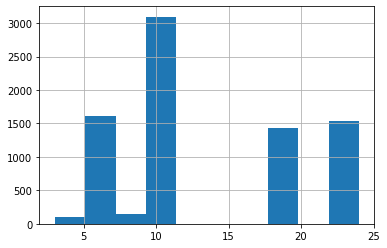

In [14]:
test[test.related == 1].predicted_topic.hist()

In [18]:
test[test.predicted_topic == 10].iloc[:10]

,id,text,related,predicted_topic
13,16,"МОСКВА, 16 ноя — РИА Новости. В России упал сп...",0,10
15,19,"МОСКВА, 16 ноя - РИА Новости. Спрос россиян на...",0,10
48,68,"МОСКВА, 15 ноя — РИА Новости. Выплаты вкладчик...",0,10
56,4286,"МОСКВА, 14 авг — РИА Новости. Рост потребитель...",0,10
85,130,"МОСКВА, 14 ноя - РИА Новости. Последние два ме...",0,10
86,131,"МОСКВА, 14 ноя - РИА Новости. Средний срок ипо...",0,10
117,171,"МОСКВА, 13 ноя - РИА Новости. Росстат продолжа...",1,10
135,204,"МОСКВА, 13 ноя - РИА Новости. Активность Банка...",0,10
138,206,"МОСКВА, 13 ноя - РИА Новости. Самые большие до...",0,10
144,214,"МОСКВА, 13 ноя – РИА Новости. Индекс потребите...",1,10


In [19]:
test[test.id == 16].text.values

array(['МОСКВА, 16 ноя — РИА Новости. В России упал спрос на сигареты, сообщает RT со ссылкой на статистику платформ фискальных данных.По данным "Платформы ОФД", с января по октябрь спрос на сигареты упал на пять процентов. А платформа "Такском" зафиксировала снижение продаж на семь процентов.При этом аналитики отмечают, что у россиян набирают популярность стики для нагревания табака. "Такском" зафиксировала рост продаж в этом сегменте в четыре с половиной раза по сравнению с январем — октябрем прошлого года.С начала года средняя цена пачки традиционных сигарет составила 115 рублей, а стиков — 135 рублей.'],
      dtype=object)

In [17]:
predictions_df[predictions_df.id == 190].stemmed_words.values

array([array(['политик', 'риск', 'фонд', 'национальн', 'благосостоян',
              'замминистр', 'финанс', 'повод', 'скольк', 'себ', 'риск',
              'политик', 'мне', 'кажет', 'немн', 'месяц', 'принцип', 'политик',
              'довольн', 'отвеч', 'минфин', 'повод', 'заявлен', 'риск',
              'бюджетн', 'политик', 'инвестиц', 'фнб', 'состав', 'нескольк',
              'принцип', 'должн', 'новости бюджетн', 'является стабильн',
              'стабильной он', 'несет сильн', 'сильных инфляцион', 'не опасн',
              'опасности дл', 'роста ц', 'при планируем',
              'планируемом инвестирован', 'инвестировании средств',
              'национального благосостоян', 'благосостояния заяв',
              'заявил журналист', 'замминистра финанс', 'колычев п', 'по повод',
              'сколько несет', 'себе инфляцион', 'рисков бюджетн', 'политика мн',
              'мне кажет', 'кажется немн', 'немного есл', 'на эт', 'это смотрет',
              'смотреть горизонт', 'г

In [20]:
test.to_csv('preidctions.csv')